In [1]:
import sys
sys.path.insert(1, './env')
sys.path.insert(1, './agents')

import gym
import pylab
import random
import aa_gun
import strategy_imitation, sarsa
import numpy as np
from collections import deque
import keras
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt

from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

EPISODES = 30000
#pip install git+git://github.com/jaredwinick/img2vec-keras.git

Using TensorFlow backend.


In [ ]:
_IMAGE_NET_TARGET_SIZE = (224, 224)

class Img2Vec(object):
    def __init__(self):
        model = resnet50.ResNet50(weights='imagenet')
        layer_name = 'avg_pool'
        self.intermediate_layer_model = Model(inputs=model.input, 
                                              outputs=model.get_layer(layer_name).output)

    def get_vec(self, image_source, is_file=False,resize_type='crop'):
        """ Gets a vector embedding from an image.
        :param image_path: path to image on filesystem
        :returns: numpy ndarray
        """
        if is_file:
            img = image.load_img(image_source, target_size=_IMAGE_NET_TARGET_SIZE)
            x = image.img_to_array(img)
        else:
            #is array. image.array_to_img(state) to show
            if resize_type=='resize':
                img = image.array_to_img(image_source) 
                img=img.resize(_IMAGE_NET_TARGET_SIZE)
                x = image.img_to_array(img)
            elif resize_type=='crop':
                x=np.zeros([_IMAGE_NET_TARGET_SIZE[0],_IMAGE_NET_TARGET_SIZE[1],3])
                x[:image_source.shape[0],:image_source.shape[1],:]=image_source
        x = np.expand_dims(x, axis=0)
        x = resnet50.preprocess_input(x)
        intermediate_output = self.intermediate_layer_model.predict(x)
        return intermediate_output[0]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 50)                102450    
_________________________________________________________________
batch_normalization_5 (Batch (None, 50)                200       
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               10200     
_________________________________________________________________
batch_normalization_6 (Batch (None, 200)               800       
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 457.6176
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 454.2953
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 459.5378
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 454.5728
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 453.3684
Epoch 1/2
500/500 [==============================] - 0s 26us/step - loss: 449.6866
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 445.1490
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 441.9534
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 448.9604
Epoch 1/2
500/500 [==============================] - 0s 56us/step - loss: 442.6811
Epoch 2/2
500/500 [==============================] - 0s 54us/step - loss: 438.5895
Epoch 1/2
500/500 [==============================] - 0s 38us/step - loss: 445.0113
Epoc

Epoch 2/2
500/500 [==============================] - 0s 49us/step - loss: 575.1848
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 565.4849
Epoch 2/2
500/500 [==============================] - 0s 32us/step - loss: 562.6504
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 562.1943
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 563.6550
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 554.2780
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 559.7402
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 549.3281
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 540.6892
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 538.6960
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 536.3162
Epoch 1/2
500/500 [==============================] - 0s 32us/step - loss: 530.5129
Epoc

Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 218.3906
Epoch 1/2
500/500 [==============================] - 0s 26us/step - loss: 213.4860
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 209.0783
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 211.1976
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 214.6322
Epoch 1/2
500/500 [==============================] - 0s 47us/step - loss: 209.0441
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 208.8931
Epoch 1/2
500/500 [==============================] - 0s 37us/step - loss: 209.9664
Epoch 2/2
500/500 [==============================] - 0s 35us/step - loss: 204.2869
Epoch 1/2
500/500 [==============================] - 0s 33us/step - loss: 202.2999
Epoch 2/2
500/500 [==============================] - 0s 35us/step - loss: 201.4824
Epoch 1/2
500/500 [==============================] - 0s 34us/step - loss: 201.3218
Epoc

Epoch 2/2
500/500 [==============================] - 0s 33us/step - loss: 68.2622
delta_r 7.249481299128236 r 12.999234252582973
Epoch 1/2
500/500 [==============================] - 0s 31us/step - loss: 314.8094
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 310.3871
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 314.6475
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 306.0013
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 310.1949
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 306.4259
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 299.2556
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 295.1009
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 291.5463
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 282.9217
Epoch 1/2
500/500 [======================

Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 144.2346
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 151.0072
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 147.6856
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 87.7309
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 90.8242
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 90.9920
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 91.8620
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 85.9336
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 82.2978
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 86.7336
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 87.2317
Epoch 1/2
500/500 [==============================] - 0s 33us/step - loss: 86.2352
Epoch 2/2
500

Epoch 1/2
500/500 [==============================] - 0s 31us/step - loss: 42.6808
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 41.9744
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 43.3573
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 39.2595
delta_r 7.780919335427603 r 13.854785228014023
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 110.3611
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 118.0870
Epoch 1/2
500/500 [==============================] - 0s 26us/step - loss: 103.6531
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 110.3665
Epoch 1/2
500/500 [==============================] - 0s 26us/step - loss: 99.5788
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 97.9837
Epoch 1/2
500/500 [==============================] - 0s 47us/step - loss: 110.3119
Epoch 2/2
500/500 [===========================

Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 73.1720
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 65.0812
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 67.8509
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 66.0703
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 70.4697
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 42.6407
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 39.7924
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 43.1711
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 40.8336
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 40.5800
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 38.4088
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 42.1398
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 32.9258
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 35.9854
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 36.2744
Epoch 2/2
500/500 [==============================] - 0s 33us/step - loss: 35.7854
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 34.8840
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 33.8882
delta_r 6.60138662097516 r 13.943911084207702
Epoch 1/2
500/500 [==============================] - 0s 37us/step - loss: 89.3737
Epoch 2/2
500/500 [==============================] - 0s 31us/step - loss: 93.1384
Epoch 1/2
500/500 [==============================] - 0s 35us/step - loss: 87.4066
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 92.5328
Epoch 1/2
500/500 [==============================] - 0s 31us/step - loss: 79.4278
Epoch 2/2
500/500 [==============================] -

Epoch 1/2
500/500 [==============================] - 0s 38us/step - loss: 62.5472
Epoch 2/2
500/500 [==============================] - 0s 35us/step - loss: 60.5295
Epoch 1/2
500/500 [==============================] - 0s 35us/step - loss: 55.8720
Epoch 2/2
500/500 [==============================] - 0s 35us/step - loss: 61.5832
Epoch 1/2
500/500 [==============================] - 0s 34us/step - loss: 67.5552
Epoch 2/2
500/500 [==============================] - 0s 34us/step - loss: 60.0197
Epoch 1/2
500/500 [==============================] - 0s 35us/step - loss: 65.4419
Epoch 2/2
500/500 [==============================] - 0s 35us/step - loss: 60.1515
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 71.4288
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 69.7437
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 68.0866
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 68.2039
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 28.7422
Epoch 1/2
500/500 [==============================] - 0s 26us/step - loss: 30.2309
Epoch 2/2
500/500 [==============================] - 0s 26us/step - loss: 30.5727
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 28.7902
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 28.7747
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 28.6055
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 28.2577
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 28.0191
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 27.6495
delta_r 5.879093919477 r 13.932881471979579
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 58.4631
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 67.6608
Epoch 1/2
500/500 [==============================] - 0

Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 55.4262
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 62.4168
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 58.6980
Epoch 2/2
500/500 [==============================] - 0s 34us/step - loss: 60.7086
Epoch 1/2
500/500 [==============================] - 0s 32us/step - loss: 52.6310
Epoch 2/2
500/500 [==============================] - 0s 34us/step - loss: 56.2378
Epoch 1/2
500/500 [==============================] - 0s 32us/step - loss: 61.6892
Epoch 2/2
500/500 [==============================] - 0s 34us/step - loss: 62.9702
Epoch 1/2
500/500 [==============================] - 0s 32us/step - loss: 57.7206
Epoch 2/2
500/500 [==============================] - 0s 34us/step - loss: 64.4943
Epoch 1/2
500/500 [==============================] - 0s 33us/step - loss: 34.8493
Epoch 2/2
500/500 [==============================] - 0s 34us/step - loss: 34.2291
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 28.8730
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 27.2266
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 26.9277
Epoch 1/2
500/500 [==============================] - 0s 33us/step - loss: 27.7737
Epoch 2/2
500/500 [==============================] - 0s 36us/step - loss: 27.4445
Epoch 1/2
500/500 [==============================] - 0s 35us/step - loss: 27.4481
Epoch 2/2
500/500 [==============================] - 0s 36us/step - loss: 26.2968
Epoch 1/2
500/500 [==============================] - 0s 34us/step - loss: 27.1582
Epoch 2/2
500/500 [==============================] - 0s 35us/step - loss: 25.8509
Epoch 1/2
500/500 [==============================] - 0s 67us/step - loss: 26.9217
Epoch 2/2
500/500 [==============================] - 0s 53us/step - loss: 26.1285
delta_r 5.3267844932673425 r 14.500068387687497
Epoch 1/2
500/500 [==============================]

Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 53.3450
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 48.3127
Epoch 1/2
500/500 [==============================] - 0s 54us/step - loss: 51.9349
Epoch 2/2
500/500 [==============================] - 0s 53us/step - loss: 52.5409
Epoch 1/2
500/500 [==============================] - 0s 34us/step - loss: 51.2843
Epoch 2/2
500/500 [==============================] - 0s 35us/step - loss: 49.7400
Epoch 1/2
500/500 [==============================] - 0s 34us/step - loss: 59.9835
Epoch 2/2
500/500 [==============================] - 0s 34us/step - loss: 54.1664
Epoch 1/2
500/500 [==============================] - 0s 32us/step - loss: 54.0524
Epoch 2/2
500/500 [==============================] - 0s 34us/step - loss: 50.2716
Epoch 1/2
500/500 [==============================] - 0s 35us/step - loss: 43.5289
Epoch 2/2
500/500 [==============================] - 0s 34us/step - loss: 45.4869
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 26.8091
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 27.5547
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 26.5565
Epoch 1/2
500/500 [==============================] - 0s 36us/step - loss: 27.2505
Epoch 2/2
500/500 [==============================] - 0s 51us/step - loss: 26.4117
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 25.9608
Epoch 2/2
500/500 [==============================] - 0s 34us/step - loss: 25.9122
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 26.4038
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 26.1376
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 25.5037
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 25.7706
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 24.7327
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 53.4397
Epoch 2/2
500/500 [==============================] - 0s 32us/step - loss: 52.3933
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 55.5357
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 48.5271
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 50.9620
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 51.4861
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 47.8343
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 49.0536
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 45.6629
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 49.2040
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 47.7925
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 51.0242
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 34.8164
Epoch 1/2
500/500 [==============================] - 0s 53us/step - loss: 34.8797
Epoch 2/2
500/500 [==============================] - 0s 53us/step - loss: 32.6283
Epoch 1/2
500/500 [==============================] - 0s 38us/step - loss: 31.6088
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 31.6805
Epoch 1/2
500/500 [==============================] - 0s 33us/step - loss: 29.5338
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 30.3614
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 27.2242
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 28.4826
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 29.0029
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 29.2481
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 27.5423
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 49.5290
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 48.7025
Epoch 1/2
500/500 [==============================] - 0s 31us/step - loss: 51.5050
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 47.6363
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 50.8169
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 49.6261
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 50.0904
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 51.8210
Epoch 1/2
500/500 [==============================] - 0s 30us/step - loss: 43.5939
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 45.7072
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 44.6878
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 45.5786
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 33us/step - loss: 27.6570
Epoch 1/2
500/500 [==============================] - 0s 32us/step - loss: 27.0189
Epoch 2/2
500/500 [==============================] - 0s 32us/step - loss: 28.2408
Epoch 1/2
500/500 [==============================] - 0s 32us/step - loss: 27.7151
Epoch 2/2
500/500 [==============================] - 0s 32us/step - loss: 28.1195
Epoch 1/2
500/500 [==============================] - 0s 33us/step - loss: 27.7077
Epoch 2/2
500/500 [==============================] - 0s 33us/step - loss: 27.5180
Epoch 1/2
500/500 [==============================] - 0s 33us/step - loss: 26.8099
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 27.4705
Epoch 1/2
500/500 [==============================] - 0s 75us/step - loss: 27.4685
Epoch 2/2
500/500 [==============================] - 0s 93us/step - loss: 26.6905
Epoch 1/2
500/500 [==============================] - 0s 30us/step - loss: 26.7212
Epoch 2/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 41.9042
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 43.5228
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 43.6455
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 39.4646
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 40.5314
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 44.9285
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 42.0422
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 36.7054
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 39.5123
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 40.5717
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 39.1455
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 37.1113
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 22.0717
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 22.4177
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 21.9232
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 21.2230
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 21.7671
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 22.3127
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 22.0555
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 22.2116
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 20.5764
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 21.6988
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 21.1907
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 20.7494
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 51us/step - loss: 178.0112
delta_r 5.733799666820493 r 14.263328440167708
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 45.5605
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 43.9009
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 43.0277
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 42.6440
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 43.4800
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 44.5784
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 42.2206
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 48.1726
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 41.8486
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 43.5476
Epoch 1/2
500/500 [==============================]

500/500 [==============================] - 0s 29us/step - loss: 42.5191
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 42.7712
Epoch 2/2
500/500 [==============================] - 0s 31us/step - loss: 45.4868
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 107.3945
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 110.2597
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 110.8303
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 108.8840
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 108.9098
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 104.9108
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 106.5578
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 102.2958
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 103.9742
Epoch 2/2
500/500

Epoch 1/2
500/500 [==============================] - 0s 36us/step - loss: 21.8932
Epoch 2/2
500/500 [==============================] - 0s 35us/step - loss: 21.3348
Epoch 1/2
500/500 [==============================] - 0s 35us/step - loss: 21.2228
Epoch 2/2
500/500 [==============================] - 0s 37us/step - loss: 20.7329
delta_r 4.591244522700549 r 14.012265854540528
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 39.0332
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 36.6758
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 39.2680
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 34.2224
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 37.8410
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 38.2948
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 34.9234
Epoch 2/2
500/500 [==============================] 

Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 37.0889
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 37.7053
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 32.6709
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 38.1384
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 33.7502
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 46.2319
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 48.3438
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 47.0879
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 45.5543
Epoch 1/2
500/500 [==============================] - 0s 50us/step - loss: 47.1589
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 45.7773
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 44.9840
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 30us/step - loss: 19.4827
Epoch 2/2
500/500 [==============================] - 0s 31us/step - loss: 20.4891
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 20.1259
Epoch 2/2
500/500 [==============================] - 0s 35us/step - loss: 19.8142
Epoch 1/2
500/500 [==============================] - 0s 33us/step - loss: 20.7560
Epoch 2/2
500/500 [==============================] - 0s 33us/step - loss: 21.2142
delta_r 4.39695082889736 r 13.48638770499118
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 41.4281
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 43.0014
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 39.2676
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 38.1556
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 39.3877
Epoch 2/2
500/500 [==============================] - 

Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 36.6047
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 46.0303
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 38.7329
Epoch 1/2
500/500 [==============================] - 0s 36us/step - loss: 40.7525
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 35.3676
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 39.2318
Epoch 2/2
500/500 [==============================] - 0s 47us/step - loss: 36.6133
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 67.7300
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 67.2465
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 67.2626
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 66.2345
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 64.9335
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 30.4324
Epoch 2/2
500/500 [==============================] - 0s 32us/step - loss: 28.5316
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 29.0472
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 29.6160
Epoch 1/2
500/500 [==============================] - 0s 31us/step - loss: 29.6246
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 28.7793
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 27.5228
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 27.3531
delta_r 6.4882388005017555 r 13.617986660223368
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 41.1520
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 41.0500
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 37.7508
Epoch 2/2
500/500 [==============================]

Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 31.6231
Epoch 1/2
500/500 [==============================] - 0s 30us/step - loss: 31.8375
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 34.5819
Epoch 1/2
500/500 [==============================] - 0s 26us/step - loss: 33.0993
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 33.1980
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 33.4728
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 29.2493
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 31.2198
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 29.5000
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 59.3252
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 58.5012
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 56.3778
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 55us/step - loss: 61.4447
Epoch 2/2
500/500 [==============================] - 0s 48us/step - loss: 61.2528
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 60.2637
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 61.7499
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 59.6377
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 59.4348
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 57.2674
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 58.9947
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 57.7047
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 58.0263
delta_r 5.521270048647909 r 13.380703718626433
Epoch 1/2
500/500 [==============================] - 0s 30us/step - loss: 41.2526
Epoch 2/2
500/500 [==============================] 

Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 35.1245
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 28.5872
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 33.0109
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 32.5771
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 30.9152
Epoch 1/2
500/500 [==============================] - 0s 31us/step - loss: 34.4916
Epoch 2/2
500/500 [==============================] - 0s 31us/step - loss: 31.2865
Epoch 1/2
500/500 [==============================] - 0s 31us/step - loss: 31.2536
Epoch 2/2
500/500 [==============================] - 0s 31us/step - loss: 29.1522
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 30.5442
Epoch 2/2
500/500 [==============================] - 0s 31us/step - loss: 31.4877
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 17.9956
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 33us/step - loss: 17.3493
Epoch 2/2
500/500 [==============================] - 0s 32us/step - loss: 17.1572
Epoch 1/2
500/500 [==============================] - 0s 32us/step - loss: 17.4858
Epoch 2/2
500/500 [==============================] - 0s 31us/step - loss: 17.0459
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 16.1333
Epoch 2/2
500/500 [==============================] - 0s 31us/step - loss: 16.8086
Epoch 1/2
500/500 [==============================] - 0s 55us/step - loss: 17.1754
Epoch 2/2
500/500 [==============================] - 0s 50us/step - loss: 17.0213
Epoch 1/2
500/500 [==============================] - 0s 31us/step - loss: 17.0834
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 15.9109
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 16.1390
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 16.2546
delta_r 3.929064

Epoch 2/2
500/500 [==============================] - 0s 31us/step - loss: 29.8032
Epoch 1/2
500/500 [==============================] - 0s 30us/step - loss: 30.4725
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 29.0824
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 30.9164
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 30.1523
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 26.8741
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 30.7436
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 27.0829
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 26.4854
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 26.8686
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 26.6514
Epoch 1/2
500/500 [==============================] - 0s 34us/step - loss: 28.9781
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 53.3903
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 54.6459
Epoch 1/2
500/500 [==============================] - 0s 26us/step - loss: 52.8579
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 52.6742
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 53.8099
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 53.2218
Epoch 1/2
500/500 [==============================] - 0s 26us/step - loss: 51.7272
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 52.3442
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 51.2745
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 51.1715
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 50.6445
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 51.1219
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 52us/step - loss: 33.7183
Epoch 1/2
500/500 [==============================] - 0s 30us/step - loss: 30.0766
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 35.1045
Epoch 1/2
500/500 [==============================] - 0s 34us/step - loss: 32.7082
Epoch 2/2
500/500 [==============================] - 0s 34us/step - loss: 32.2138
Epoch 1/2
500/500 [==============================] - 0s 34us/step - loss: 33.8532
Epoch 2/2
500/500 [==============================] - 0s 33us/step - loss: 33.5342
Epoch 1/2
500/500 [==============================] - 0s 33us/step - loss: 32.7598
Epoch 2/2
500/500 [==============================] - 0s 32us/step - loss: 32.0530
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 29.2430
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 32.7610
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 30.9662
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 18.5479
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 18.4365
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 18.4527
Epoch 2/2
500/500 [==============================] - 0s 32us/step - loss: 18.0443
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 17.4864
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 17.8619
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 18.0933
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 17.2128
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 16.9740
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 17.2943
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 16.6195
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 17.0527
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 33.2246
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 33.5551
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 31.6400
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 29.3246
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 31.1297
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 31.0812
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 30.7064
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 30.5305
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 31.8253
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 29.1299
Epoch 2/2
500/500 [==============================] - 0s 54us/step - loss: 29.8022
Epoch 1/2
500/500 [==============================] - 0s 56us/step - loss: 30.3692
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 34.6407
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 34.4652
Epoch 1/2
500/500 [==============================] - 0s 26us/step - loss: 34.0004
Epoch 2/2
500/500 [==============================] - 0s 26us/step - loss: 33.4191
Epoch 1/2
500/500 [==============================] - 0s 26us/step - loss: 33.2216
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 31.4794
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 32.6731
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 32.0775
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 31.7791
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 31.0473
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 31.4671
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 30.8994
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 30.0283
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 31.2182
Epoch 2/2
500/500 [==============================] - 0s 60us/step - loss: 29.2725
Epoch 1/2
500/500 [==============================] - 0s 59us/step - loss: 32.0746
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 28.6063
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 31.8770
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 32.2812
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 28.9951
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 30.8834
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 31.5244
Epoch 2/2
500/500 [==============================] - 0s 33us/step - loss: 27.2990
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 29.2381
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 21.0381
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 21.7528
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 20.6456
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 20.1781
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 20.4101
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 20.5077
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 19.8188
Epoch 2/2
500/500 [==============================] - 0s 35us/step - loss: 18.8881
Epoch 1/2
500/500 [==============================] - 0s 49us/step - loss: 19.0364
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 19.1398
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 18.6562
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 18.7348
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 92.6237
delta_r 7.2529426374621035 r 15.045593307668698
Epoch 1/2
500/500 [==============================] - 0s 35us/step - loss: 30.5723
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 31.9618
Epoch 1/2
500/500 [==============================] - 0s 54us/step - loss: 35.1496
Epoch 2/2
500/500 [==============================] - 0s 51us/step - loss: 32.7742
Epoch 1/2
500/500 [==============================] - 0s 32us/step - loss: 32.7352
Epoch 2/2
500/500 [==============================] - 0s 34us/step - loss: 35.0151
Epoch 1/2
500/500 [==============================] - 0s 32us/step - loss: 34.1687
Epoch 2/2
500/500 [==============================] - 0s 36us/step - loss: 31.7940
Epoch 1/2
500/500 [==============================] - 0s 36us/step - loss: 28.0232
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 29.7951
Epoch 1/2
500/500 [==============================]

Epoch 1/2
500/500 [==============================] - 0s 86us/step - loss: 30.5599
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 28.4054
Epoch 1/2
500/500 [==============================] - 0s 34us/step - loss: 57.9243
Epoch 2/2
500/500 [==============================] - 0s 34us/step - loss: 58.0331
Epoch 1/2
500/500 [==============================] - 0s 35us/step - loss: 57.4858
Epoch 2/2
500/500 [==============================] - 0s 34us/step - loss: 57.5626
Epoch 1/2
500/500 [==============================] - 0s 35us/step - loss: 56.9049
Epoch 2/2
500/500 [==============================] - 0s 35us/step - loss: 56.0751
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 56.1949
Epoch 2/2
500/500 [==============================] - 0s 37us/step - loss: 55.7019
Epoch 1/2
500/500 [==============================] - 0s 35us/step - loss: 55.9523
Epoch 2/2
500/500 [==============================] - 0s 36us/step - loss: 55.4548
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 22.1475
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 21.2975
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 21.7205
delta_r 4.426049588445797 r 14.170691273100335
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 35.2929
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 33.3449
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 33.3108
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 34.7177
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 31.6095
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 33.6078
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 32.8297
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 33.0158
Epoch 1/2
500/500 [==============================] 

Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 27.4125
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 27.6198
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 29.2978
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 26.9792
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 27.0416
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 30.5415
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 31.0288
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 29.7241
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 30.1122
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 29.3840
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 29.4610
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 29.2592
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 20.5425
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 20.4584
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 21.0542
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 20.3392
Epoch 1/2
500/500 [==============================] - 0s 30us/step - loss: 19.8017
Epoch 2/2
500/500 [==============================] - 0s 35us/step - loss: 19.5550
delta_r 4.72986394164935 r 13.554929638053776
Epoch 1/2
500/500 [==============================] - 0s 33us/step - loss: 32.5718
Epoch 2/2
500/500 [==============================] - 0s 33us/step - loss: 32.0352
Epoch 1/2
500/500 [==============================] - 0s 33us/step - loss: 28.5362
Epoch 2/2
500/500 [==============================] - 0s 34us/step - loss: 34.0781
Epoch 1/2
500/500 [==============================] - 0s 33us/step - loss: 29.1315
Epoch 2/2
500/500 [==============================] -

Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 26.4773
Epoch 1/2
500/500 [==============================] - 0s 26us/step - loss: 29.3317
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 28.6768
Epoch 1/2
500/500 [==============================] - 0s 51us/step - loss: 24.8917
Epoch 2/2
500/500 [==============================] - 0s 66us/step - loss: 26.7641
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 26.3224
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 25.3674
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 33.2539
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 33.0920
Epoch 1/2
500/500 [==============================] - 0s 26us/step - loss: 32.5606
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 33.5348
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 32.8666
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 23.9561
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 23.6531
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 24.2293
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 23.7673
Epoch 1/2
500/500 [==============================] - 0s 26us/step - loss: 23.5408
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 23.3584
Epoch 1/2
500/500 [==============================] - 0s 26us/step - loss: 23.4674
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 23.6233
delta_r 4.2186124935837555 r 13.32023753148536
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 42.5611
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 41.2147
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 40.8991
Epoch 2/2
500/500 [==============================] 

Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 31.3270
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 29.9035
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 33.4046
Epoch 2/2
500/500 [==============================] - 0s 33us/step - loss: 31.8881
Epoch 1/2
500/500 [==============================] - 0s 68us/step - loss: 29.5053
Epoch 2/2
500/500 [==============================] - 0s 49us/step - loss: 30.0666
Epoch 1/2
500/500 [==============================] - 0s 34us/step - loss: 30.5858
Epoch 2/2
500/500 [==============================] - 0s 34us/step - loss: 28.8255
Epoch 1/2
500/500 [==============================] - 0s 33us/step - loss: 29.4738
Epoch 2/2
500/500 [==============================] - 0s 34us/step - loss: 28.0518
Epoch 1/2
500/500 [==============================] - 0s 34us/step - loss: 29.5456
Epoch 2/2
500/500 [==============================] - 0s 35us/step - loss: 27.7368
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 21.6717
Epoch 1/2
500/500 [==============================] - 0s 55us/step - loss: 22.0117
Epoch 2/2
500/500 [==============================] - 0s 60us/step - loss: 21.3624
Epoch 1/2
500/500 [==============================] - 0s 33us/step - loss: 20.7421
Epoch 2/2
500/500 [==============================] - 0s 31us/step - loss: 20.5441
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 19.6339
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 19.4811
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 19.8665
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 19.5871
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 20.0418
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 19.9880
delta_r 4.576691045367614 r 13.424122319260876
Epoch 1/2
500/500 [==============================] 

Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 26.7628
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 25.7285
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 25.0652
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 26.5707
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 25.2576
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 25.2458
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 25.6778
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 23.9148
Epoch 1/2
500/500 [==============================] - 0s 30us/step - loss: 24.4296
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 26.2117
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 26.2409
Epoch 2/2
500/500 [==============================] - 0s 31us/step - loss: 25.1515
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 31us/step - loss: 18.8393
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 18.7382
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 18.9691
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 18.3802
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 17.7926
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 17.8317
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 18.0421
Epoch 1/2
500/500 [==============================] - 0s 31us/step - loss: 17.6023
Epoch 2/2
500/500 [==============================] - 0s 32us/step - loss: 17.7459
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 17.6144
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 17.4148
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 17.6988
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 24.3859
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 21.0661
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 24.4628
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 21.1380
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 20.6669
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 25.1688
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 22.7789
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 19.2333
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 20.6202
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 19.9973
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 21.5259
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 20.2474
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 65.2730
Epoch 1/2
500/500 [==============================] - 0s 38us/step - loss: 63.7030
Epoch 2/2
500/500 [==============================] - 0s 35us/step - loss: 63.7536
Epoch 1/2
500/500 [==============================] - 0s 38us/step - loss: 63.0424
Epoch 2/2
500/500 [==============================] - 0s 34us/step - loss: 62.9531
Epoch 1/2
500/500 [==============================] - 0s 36us/step - loss: 61.8600
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 61.5447
Epoch 1/2
500/500 [==============================] - 0s 53us/step - loss: 61.1172
Epoch 2/2
500/500 [==============================] - 0s 47us/step - loss: 60.9520
Epoch 1/2
500/500 [==============================] - 0s 36us/step - loss: 60.8015
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 60.4373
Epoch 1/2
500/500 [==============================] - 0s 34us/step - loss: 60.9977
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 37us/step - loss: 21.1710
Epoch 2/2
500/500 [==============================] - 0s 37us/step - loss: 23.4500
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 21.6206
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 21.8004
Epoch 1/2
500/500 [==============================] - 0s 26us/step - loss: 22.4986
Epoch 2/2
500/500 [==============================] - 0s 31us/step - loss: 23.1750
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 22.2216
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 23.6378
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 18.6798
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 23.0026
Epoch 1/2
500/500 [==============================] - 0s 51us/step - loss: 22.8134
Epoch 2/2
500/500 [==============================] - 0s 52us/step - loss: 22.6157
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 34us/step - loss: 16.3959
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 17.1469
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 15.8981
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 15.6764
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 15.6385
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 15.9487
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 15.2712
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 16.1108
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 15.3944
Epoch 1/2
500/500 [==============================] - 0s 36us/step - loss: 15.2831
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 15.2420
Epoch 1/2
500/500 [==============================] - 0s 37us/step - loss: 15.0294
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 34us/step - loss: 27.0308
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 28.6694
Epoch 1/2
500/500 [==============================] - 0s 56us/step - loss: 28.7399
Epoch 2/2
500/500 [==============================] - 0s 57us/step - loss: 27.7735
Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 26.4112
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 26.0838
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 25.0553
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 27.5926
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 26.3976
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 25.3119
Epoch 1/2
500/500 [==============================] - 0s 40us/step - loss: 23.9541
Epoch 2/2
500/500 [==============================] - 0s 37us/step - loss: 23.4822
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 15.5265
Epoch 1/2
500/500 [==============================] - 0s 26us/step - loss: 15.6307
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 15.6740
Epoch 1/2
500/500 [==============================] - 0s 26us/step - loss: 15.6419
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 15.4092
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 15.7921
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 15.0983
Epoch 1/2
500/500 [==============================] - 0s 31us/step - loss: 15.1852
Epoch 2/2
500/500 [==============================] - 0s 32us/step - loss: 15.2068
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 14.6916
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 15.3424
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 15.2223
Epoch 2/2
500/50

delta_r 6.017732145678011 r 13.536387273684419
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 33.7901
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 31.9324
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 34.9811
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 31.4773
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 31.7861
Epoch 2/2
500/500 [==============================] - 0s 31us/step - loss: 32.6866
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 30.3088
Epoch 2/2
500/500 [==============================] - 0s 31us/step - loss: 31.6780
Epoch 1/2
500/500 [==============================] - 0s 26us/step - loss: 30.6508
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 30.8111
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 30.6823
Epoch 2/2
500/500 [==============================] 

Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 25.0693
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 18.0959
Epoch 2/2
500/500 [==============================] - 0s 35us/step - loss: 16.8069
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 17.0891
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 17.4459
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 16.1873
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 15.5977
Epoch 1/2
500/500 [==============================] - 0s 26us/step - loss: 16.0501
Epoch 2/2
500/500 [==============================] - 0s 27us/step - loss: 16.0063
Epoch 1/2
500/500 [==============================] - 0s 26us/step - loss: 15.5917
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 15.3084
Epoch 1/2
500/500 [==============================] - 0s 26us/step - loss: 15.4078
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 31.1066
Epoch 2/2
500/500 [==============================] - 0s 28us/step - loss: 31.0518
delta_r 4.139750046492406 r 14.55610019908479
Epoch 1/2
500/500 [==============================] - 0s 65us/step - loss: 33.4477
Epoch 2/2
500/500 [==============================] - 0s 56us/step - loss: 29.8227
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 34.2308
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 30.7606
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 33.1759
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 28.6157
Epoch 1/2
500/500 [==============================] - 0s 30us/step - loss: 32.7302
Epoch 2/2
500/500 [==============================] - 0s 30us/step - loss: 30.2767
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 30.1445
Epoch 2/2
500/500 [==============================] -

Epoch 2/2
500/500 [==============================] - 0s 64us/step - loss: 20.1467
Epoch 1/2
500/500 [==============================] - 0s 50us/step - loss: 23.7083
Epoch 2/2
500/500 [==============================] - 0s 31us/step - loss: 22.7170
Epoch 1/2
500/500 [==============================] - 0s 27us/step - loss: 22.7987
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 22.9035
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 21.6981
Epoch 2/2
500/500 [==============================] - 0s 31us/step - loss: 20.2880
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 19.7503
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 19.4319
Epoch 1/2
500/500 [==============================] - 0s 28us/step - loss: 18.2244
Epoch 2/2
500/500 [==============================] - 0s 29us/step - loss: 17.3775
Epoch 1/2
500/500 [==============================] - 0s 29us/step - loss: 17.3633
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 34us/step - loss: 55.8467
Epoch 2/2
500/500 [==============================] - 0s 36us/step - loss: 56.1993
Epoch 1/2
500/500 [==============================] - 0s 34us/step - loss: 55.3289
Epoch 2/2
500/500 [==============================] - 0s 33us/step - loss: 56.0652
delta_r 7.054844381243165 r 14.458154565754745
Epoch 1/1
3475/3475 [==============================] - 0s 27us/step - loss: 25.8710
Epoch 1/1
3475/3475 [==============================] - 0s 18us/step - loss: 15.9900
delta_r 5.816017038743082 r 13.112001112487638
episode: 3   score: 200.0 125.0   memory length: 3475   epsilon: 0.030908048516573555
Epoch 1/1
4327/4327 [==============================] - 0s 31us/step - loss: 30.1312
Epoch 1/1
4327/4327 [==============================] - 0s 24us/step - loss: 21.9284
delta_r 6.008897389835576 r 12.735387422224038
episode: 4   score: 140.0 128.0   memory length: 4327   epsilon: 0.0131785477295791
Epoch 1/1
5078/5078 [====

KeyboardInterrupt: 

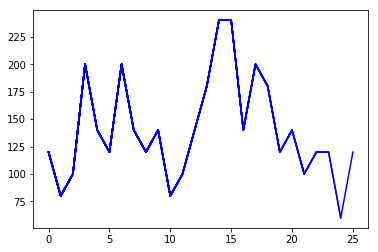

In [9]:
# In case of CartPole-v1, maximum length of episode is 500
#env = aa_gun.AA_gun_simple0_env()
env = gym.make('Seaquest-v0')

#env=CartPoleEnv9()
# get size of state and action from environment
state_size = 2048 #размер эмбеддинга
action_size = env.action_space.n

#agent = DoubleDQNAgent(state_size, action_size)
agent = sarsa.SarsaAgent(state_size, action_size,layers_size=[50,200])
agent.train_start=3000
#agent = strategy_imitation.ImitAgent(state_size, action_size)
agent.render=True

scores, episodes = [], []
reward_lst = []
s_list=[]
a_list=[]

i2v=Img2Vec()

for e in range(EPISODES):
    done = False
    score = 0
    state = env.reset()

    while not done:
        if (e in range(100,300)) or (e in range(300,306)) or (e in range(400,406)) or (e in range(500,506)) or (e in range(600,604)):
            if agent.render:
                env.render()

        # get action for the current state and go one step in environment
        if state.shape!=(1,2048):
            state=i2v.get_vec(state)
        state = np.reshape(state, [1, state_size])
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        
        next_state=i2v.get_vec(next_state)
        next_state = np.reshape(next_state, [1, state_size])
        # if an action make the episode end, then gives penalty of -100
        

        # save the sample <s, a, r, s'> to the replay memory
        reward_curr=reward
        #if done:
        #    reward_curr -= 100
        agent.append_sample(state, action, reward_curr, next_state, done)
        #if next_state[0,11]!=reward:
        #    print('state[13]!=reward',state[0,11],reward)
        #
        s_list.append(state)
        a_list.append(action)
        reward_lst.append(reward)
        #
        
        # every time step do the training
        agent.train_model()
        score += reward
        state = next_state

        if done:
            # every episode update the target model to be same with model
            agent.update_target_model()

            # every episode, plot the play time
            scores.append(score)
            episodes.append(e)
            pylab.plot(episodes, scores, 'b')
            #pylab.savefig("./save_graph/aa_gun_dqn.png")
            print("episode:", e, "  score:", score,np.mean(scores), "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon)

            # if the mean of scores of last 10 episode is bigger than 490
            # stop training

    # save the model
    #if e % 50 == 0:
    #    agent.model.save_weights("./save_model/aa_gun_dqn.h5")

In [10]:
def make_sar_table(s,a,r):
    #print(np.array(a,ndmin=2).T.shape)
    #print(np.array(r,ndmin=2).T.shape)
    #print(np.array(s,ndmin=2)[:,0,:].shape)
    return np.hstack( (np.array(s,ndmin=2)[:,0,:],np.array(a,ndmin=2).T,np.array(r,ndmin=2).T) )

0.14724323449698637


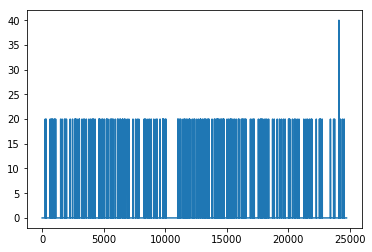

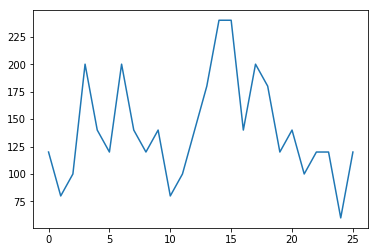

In [11]:
import matplotlib.pyplot as plt
print(np.mean(reward_lst))
plt.plot(reward_lst)
plt.show()
plt.plot(scores)

In [15]:
np.mean(scores)

140.0

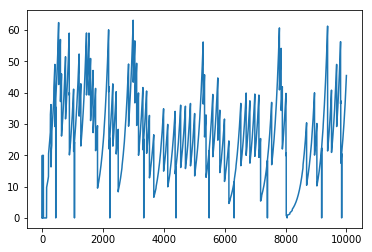

In [12]:
plt.plot(agent.r_disco)
#plt.plot(agent.d*20)

In [13]:
np.mean(reward_lst)

0.14724323449698637

In [14]:
np.mean(score)

0.0

In [ ]:
#Чтобы анализировать разрешимость задачи
def replicate_reward(sar,border=0,wanted_part=0.5):
    part = np.mean(sar[:,-1:]>border)
    if part==0:
        print('ERROR')
        return(sar)
    else:
        while part<wanted_part:
            sar=np.vstack((sar,sar[np.where(sar[:,-1:]>border)[0],:]))
            part = np.mean(sar[:,-1:]>border)
        print(part)
        return(sar)

In [ ]:
sar=make_sar_table(s_list,a_list,reward_lst)
sar=replicate_reward(sar)
X=sar[1:,:]
Y=sar[:-1,:]
Y=sar[:-1,-1:]
Y=sar[1:,-1:]
sar_width=X.shape[1]
nn = Sequential()
nn.add(Dense(200, input_dim=sar_width, activation='relu',
                kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.01)))
nn.add(BatchNormalization())
nn.add(Dropout(0.2))
nn.add(Dense(200, activation='relu',
                kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.01)))
nn.add(Dropout(0.2))
nn.add(BatchNormalization())
nn.add(Dense(200, activation='relu',
                kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.01)))
nn.add(Dropout(0.2))
nn.add(BatchNormalization())
#nn.add(Dense(sar_width, activation='linear',
#                kernel_initializer='he_uniform'))
nn.add(Dense(1, activation='linear',
                kernel_initializer='he_uniform'))

nn.summary()
nn.compile(loss='mse', optimizer=Adam(lr=0.001))
l=X.shape[0]
X_train=X[:int(l/2),:]
Y_train=Y[:int(l/2),:]
X_test=X[int(l/2):,:]
Y_test=Y[int(l/2):,:]
nn.fit(X_train, Y_train, batch_size=1200,epochs=30000, verbose=1)

In [ ]:
Y_pred=np.array(nn.predict(X_test),ndmin=2)
mse = np.mean((Y_pred-Y_test)**2)
print(mse)
rmae=np.mean(np.abs(Y_pred-Y_test))/np.mean(np.abs(Y_test))
print(rmae)
rmae_diversed=np.mean(np.abs(Y_pred-Y_test),axis=0)/np.mean(np.abs(Y_test),axis=0)
print(rmae_diversed)

In [ ]:
colnumn_num=-1
plt.plot(Y_pred[:3000,colnumn_num])
plt.plot(Y_test[:3000,colnumn_num])
plt.show()

In [ ]:
#train (переобучение?)
Y_pred=np.array(nn.predict(X_train),ndmin=2)
mse = np.mean((Y_pred-Y_train)**2)
print(mse)
rmae=np.mean(np.abs(Y_pred-Y_train))/np.mean(np.abs(Y_train))
print(rmae)
rmae_diversed=np.mean(np.abs(Y_pred-Y_train),axis=0)/np.mean(np.abs(Y_train),axis=0)
print(rmae_diversed)

colnumn_num=-1
plt.plot(Y_pred[:1300,colnumn_num])
plt.plot(Y_train[:1300,colnumn_num])
plt.show()

In [ ]:
import xgboost as xgb
xgbparams = {
    'booster':'gbtree',
    'metric':'mse',
    'objective':'reg:squarederror',
    'verbosity':0,
    'max_depth': 7,
    'n_estimators': 90,
    'eta': 0.3,
    'nthreads': 2,
    'seed':0
}
nn=xgb.XGBRegressor(**xgbparams)
nn.fit(X_train[:int(l/4),:], Y_train[:int(l/4),:],
           eval_set=[(X_train[int(l/4):,:], Y_train[int(l/4):,:])],
           verbose=True)

In [ ]:
%%time
for i in range(10):
    i2v.get_vec(next_state,resize_type='crop')